In [1]:
from pathlib import Path
import time 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
#Hyperparameters
AUTOTUNE = tf.data.AUTOTUNE
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
HEIGHT, WIDTH = 64, 64
NUM_CLASSES = 5
LR = 1e-3
EPOCHS = 40

#Directories
TRAIN_DIR = Path.cwd().parent / "dataset" / "train"
TEST_DIR = Path.cwd().parent / "dataset" / "test"

num_of_val_files = sum(path.is_file() for path in Path(TRAIN_DIR).rglob('*'))

In [3]:
class_names = ["bighorn", "butterfly", "camel", "chimpanzee", "pig"]

ds_train = keras.utils.image_dataset_from_directory(
    TRAIN_DIR, 
    labels = "inferred",
    label_mode = "categorical", 
    class_names = class_names, 
    color_mode = "rgb", 
    batch_size = BATCH_SIZE,
    image_size =(HEIGHT, WIDTH), 
    shuffle = True, 
    seed = 47, 
    validation_split = VALIDATION_SPLIT,
    subset = "training"
)

ds_val = keras.utils.image_dataset_from_directory(
    TRAIN_DIR, 
    labels = "inferred",
    label_mode = "categorical", 
    class_names = class_names, 
    color_mode = "rgb", 
    batch_size = BATCH_SIZE,
    image_size =(HEIGHT, WIDTH), 
    shuffle = True, 
    seed = 47, 
    validation_split=VALIDATION_SPLIT, 
    subset = "validation"
)

ds_test = keras.utils.image_dataset_from_directory(
    TEST_DIR, 
    labels = "inferred",
    label_mode = "categorical", 
    class_names = class_names, 
    color_mode = "rgb", 
    batch_size = num_of_val_files,
    image_size =(HEIGHT, WIDTH), 
    shuffle = True, 
    seed = 47,
)

Found 2164 files belonging to 5 classes.
Using 1732 files for training.
Found 2164 files belonging to 5 classes.
Using 432 files for validation.
Found 250 files belonging to 5 classes.


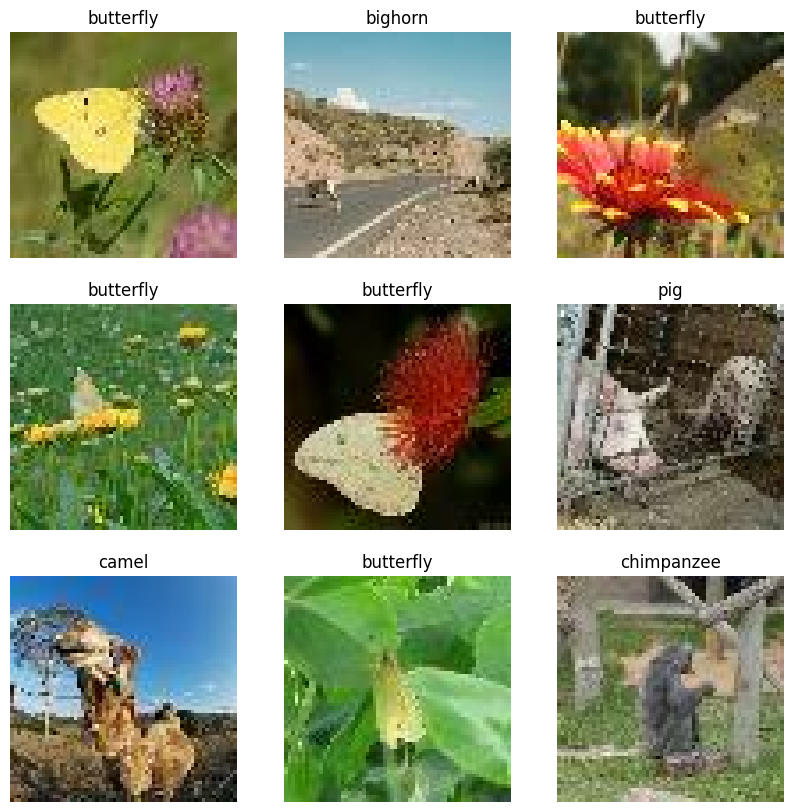

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [5]:
standardize_image = tf.image.per_image_standardization
normalization = keras.layers.Rescaling(1./255)

ds_train = ds_train.map(lambda x, y: (normalization(x), y))
ds_train = ds_train.map(lambda x, y: (standardize_image(x), y)) 
ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)

ds_val = ds_val.map(lambda x, y: (normalization(x), y))
ds_val = ds_val.map(lambda x, y: (standardize_image(x), y)) 
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

ds_test = ds_test.map(lambda x, y: (normalization(x), y))
ds_test = ds_test.map(lambda x, y: (standardize_image(x), y)) 
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
def define_model(img_height, img_width, num_classes):
    inputs = keras.Input(shape=(img_height, img_width, 3), name="images")
    flatten = keras.layers.Flatten(input_shape=(img_height, img_width, 3), name="input_layer")(inputs)

    h1 = keras.layers.Dense(512, activation="selu", kernel_initializer="lecun_normal", name="hidden_layer_1")(flatten)
    h2 = keras.layers.Dense(256, activation="selu", kernel_initializer="lecun_normal", name="hidden_layer_2")(h1)
    h3 = keras.layers.Dense(128, activation="selu", kernel_initializer="lecun_normal", name="hidden_layer_3")(h2)
    
    outputs = keras.layers.Dense(num_classes, activation="softmax", name="predictions")(h3)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model 

In [7]:
model = define_model(HEIGHT, WIDTH, NUM_CLASSES)
model.summary()
keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 64, 64, 3)]       0         
                                                                 
 input_layer (Flatten)       (None, 12288)             0         
                                                                 
 hidden_layer_1 (Dense)      (None, 512)               6291968   
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               131328    
                                                                 
 hidden_layer_3 (Dense)      (None, 128)               32896     
                                                                 
 predictions (Dense)         (None, 5)                 645       
                                                                 
Total params: 6456837 (24.63 MB)
Trainable params: 6456837 (2

In [8]:
optimizer = keras.optimizers.SGD(learning_rate=LR)
loss_fn = keras.losses.CategoricalCrossentropy()

train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

In [9]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        probabilities = model(x, training=True)
        loss_value = loss_fn(y, probabilities)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, probabilities)
    return loss_value

In [10]:
@tf.function
def val_step(x, y):
    val_probabilities = model(x, training=False)
    val_acc_metric.update_state(y, val_probabilities)

In [11]:
for epoch in range(EPOCHS):
    print(f"Start of Epoch {epoch}")
    start_time = time.time()

    for step, (x_batch_train, y_batch_train) in enumerate(ds_train):
        loss_value = train_step(x_batch_train, y_batch_train)

        if step % 200 == 0:
            print(
                f"Training loss (for one batch) at step {step}: {float(loss_value):.4f}"
            )
            print(f"Seen so far: {(step + 1) * BATCH_SIZE} samples")

    train_acc = train_acc_metric.result()
    print(f"Training acc over epoch: {float(train_acc):.4f}")

    train_acc_metric.reset_states()

    for x_batch_val, y_batch_val in ds_val:
        val_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print(f"Validation acc: {float(val_acc):.4f}")
    print(f"Time taken: {time.time() - start_time:.2f}s")


Start of Epoch 0
Training loss (for one batch) at step 0: 1.8739
Seen so far: 32 samples
Training acc over epoch: 0.4330
Validation acc: 0.4074
Time taken: 2.76s
Start of Epoch 1
Training loss (for one batch) at step 0: 0.9936
Seen so far: 32 samples
Training acc over epoch: 0.5987
Validation acc: 0.4861
Time taken: 1.13s
Start of Epoch 2
Training loss (for one batch) at step 0: 0.6430
Seen so far: 32 samples
Training acc over epoch: 0.6975
Validation acc: 0.4931
Time taken: 1.06s
Start of Epoch 3
Training loss (for one batch) at step 0: 0.5067
Seen so far: 32 samples
Training acc over epoch: 0.7870
Validation acc: 0.5046
Time taken: 1.03s
Start of Epoch 4
Training loss (for one batch) at step 0: 0.4264
Seen so far: 32 samples
Training acc over epoch: 0.8482
Validation acc: 0.5046
Time taken: 1.05s
Start of Epoch 5
Training loss (for one batch) at step 0: 0.3627
Seen so far: 32 samples
Training acc over epoch: 0.8903
Validation acc: 0.5023
Time taken: 1.13s
Start of Epoch 6
Training lo

In [12]:
Xte, yte = next(iter(ds_test)) 
probabilities = model.predict(Xte)
y_pred = tf.one_hot(tf.argmax(probabilities, axis=1), probabilities.shape[1])

y_pred = tf.argmax(y_pred, axis=-1)
yte = tf.argmax(yte, axis=-1)

8/8 [==============================] - 0s 5ms/step


In [13]:
def reports(y_test, y_pred, labels):
  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  f1 = f1_score(y_test, y_pred, average='weighted')
  sensitivity = recall_score(y_test, y_pred, average=None)
  specificity = []
  for i in range(len(conf_matrix)):
      true_negatives = sum(conf_matrix[j][j] for j in range(len(conf_matrix)) if j != i)
      false_positives = sum(conf_matrix[j][i] for j in range(len(conf_matrix)) if j != i)
      specificity.append(true_negatives / (true_negatives + false_positives))

  ppv = precision_score(y_test, y_pred, average=None)

  for i in range(len(conf_matrix)):
      true_negatives = sum(conf_matrix[j][j] for j in range(len(conf_matrix)) if j != i)
      false_negatives = sum(conf_matrix[i][j] for j in range(len(conf_matrix)) if j != i)
      npv = (true_negatives / (true_negatives + false_negatives))
      print(f'Class {labels[i]} - ',end='')
      print("Sensitivity:", round(sensitivity[i], 5), end=', ')
      print("Specificity:", round(specificity[i], 5), end=', ')
      print("Positive Predictive Value (PPV):", round(ppv[i], 5),end=', ')
      print("Negative Predictive Value (NPV):", round(npv,5))

  print()
  print("Accuracy:", round(accuracy, 5))
  print("Confusion Matrix:")
  print(conf_matrix)
  print("F1 Score:", round(f1, 5))
  print()
  print("Classification metrics:")
  print(classification_report(y_test, y_pred, digits = 3, target_names = class_names))
  print()

print('\nFor testing:\n')
reports(yte, y_pred, class_names)


For testing:

Class bighorn - Sensitivity: 0.14, Specificity: 0.85211, Positive Predictive Value (PPV): 0.25, Negative Predictive Value (NPV): 0.7378
Class butterfly - Sensitivity: 0.9, Specificity: 0.89247, Positive Predictive Value (PPV): 0.81818, Negative Predictive Value (NPV): 0.94318
Class camel - Sensitivity: 0.64, Specificity: 0.68085, Positive Predictive Value (PPV): 0.41558, Negative Predictive Value (NPV): 0.84211
Class chimpanzee - Sensitivity: 0.72, Specificity: 0.736, Positive Predictive Value (PPV): 0.52174, Negative Predictive Value (NPV): 0.86792
Class pig - Sensitivity: 0.16, Specificity: 0.90226, Positive Predictive Value (PPV): 0.38095, Negative Predictive Value (NPV): 0.74074

Accuracy: 0.512
Confusion Matrix:
[[ 7  3 19 12  9]
 [ 0 45  5  0  0]
 [ 7  2 32  6  3]
 [ 5  1  7 36  1]
 [ 9  4 14 15  8]]
F1 Score: 0.47419

Classification metrics:
              precision    recall  f1-score   support

     bighorn      0.250     0.140     0.179        50
   butterfly   